In [2]:
import datetime
import time
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from operator import itemgetter
from itertools import groupby

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
from imblearn.under_sampling import EditedNearestNeighbours # doctest: +NORMALIZE_WHITESPACE

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import decomposition, tree
import pydot



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
def converter(currency,amount):
    coversion_dict = {'SEK':0.09703,'MXN':0.04358,'AUD':0.63161,'NZD':0.58377,'GBP':1.13355}
    return round(amount * coversion_dict[currency])

In [4]:
dataset = pd.read_csv('data_for_student_case.csv')
#Construct the dataframe format
#Delete entries that have been recognised as Refuced transactions
dataset = dataset.loc[dataset['simple_journal']!='Refused']
dataset = dataset.loc[dataset['mail_id']!='emailNA']                           
#Convert amount into Euros
dataset['EuroAmount']=dataset.apply(lambda row: converter(row['currencycode'],row['amount']),axis=1)
dataset['creationdate'] = pd.to_datetime(dataset['creationdate'],format='%Y-%m-%d %H:%M:%S')
dataset['bookingdate'] = pd.to_datetime(dataset['bookingdate'],format='%Y-%m-%d %H:%M:%S')
dataset['creation_month'] = dataset.creationdate.dt.month
dataset['creation_year'] = dataset.creationdate.dt.year
dataset['creation_day'] = dataset.creationdate.dt.day
dataset['creation_hour'] = dataset.creationdate.dt.hour
#convert label into 1 and 0
dataset['label'] = np.where(dataset['simple_journal']=='Chargeback', 1, 0)

In [5]:
selected_features = [ 'issuercountrycode', 'txvariantcode', 'EuroAmount', 'amount',
                            'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'simple_journal',
                            'cvcresponsecode', 'accountcode','creation_hour', 'creation_day','creation_month', 'creation_year', 'ip_id', 'mail_id', 'bin', 'card_id']


all_features = dataset[selected_features]

# Remove samples which have empty columns
# propably generates new keys
all_features = all_features.dropna(axis=0, how='any')

# print(np.asarray(all_features).shape)

all_features['label'] = np.where(all_features['simple_journal']=='Chargeback', 1, 0)
label = all_features['label']
enc_label = all_features['label']
all_features = all_features.drop(['txvariantcode','amount','creation_hour', 'creation_month', 'creation_year','simple_journal', 'label', 'mail_id', 'ip_id'],axis=1)

#this function is created specifically for the columns mail_id, ip_id, card_id, bin
#these columns usually contain unique data since each one of these are personal
#we identified some patterns, like that the most of the bins are used many times
#also there are card_ids frequently used
#we add this information as feature to see if our results will become better
def personal_data_encoding(column, threshold):
    count = dict(all_features[column].value_counts())
    mapping = {}
    for id in count.keys():
        if count[id]>threshold:
            mapping[id] = id
        else:
        	#we don't care for the appearances of 
            mapping[id] = 'dc'
    all_features[column] = all_features[column].map(mapping)


personal_data_encoding('bin',3)
personal_data_encoding('card_id',10)
encoded_feat = pd.get_dummies(all_features)

In [6]:
def pca(feature_vector, labels, comp=200):
    pca = decomposition.PCA(n_components=comp)
    coeff = pca.fit_transform(feature_vector)
    return coeff

In [7]:
comp = 100
test_feature = pca(encoded_feat, enc_label, comp)
test_ff = pd.DataFrame(test_feature)

In [8]:
TP, FP, FN, TN = 0, 0, 0, 0
x_array = np.array(test_ff)
y_array = np.array(enc_label)
usx = x_array
usy = y_array
usx = usx.astype(np.float64)
usy = usy.astype(np.float64)
# print(usx.shape)

In [9]:
def classification(data_manipulation, classifier):
    
    warnings.filterwarnings("ignore")
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    if classifier == 'knn':
        print("KNN Classifier")
        clf = neighbors.KNeighborsClassifier(n_jobs=-1)
    elif classifier == 'random forest':
        print("Random Forest Classifier")
        clf = RandomForestClassifier(n_jobs=-1)
    elif classifier == 'adaboost':
        print("AdaBoost Classifier")
        clf = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=42)
    elif classifier == 'decision_tree':
        print("Decision Tree Classifier")
        clf = tree.DecisionTreeClassifier()
            
    

    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0
    total_prob = []

    tprs_set = []
    fprs_set = []
    fns_set = []
    tns_set = []
    y_set = []
    probs_set = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    j = 0

    if data_manipulation == 'SMOTE':
        print("SMOTE")
    elif data_manipulation == 'SMOTE + Tomek':
        print("SMOTE + Tomek")
    elif data_manipulation == 'UnderSampling':
        print("UnderSampling")
    elif data_manipulation == 'pure':
        print("Wihtout data augmentation")

    for train_index, test_index in kf.split(usx, usy):
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        [x_train, x_test] = usx[train_index], usx[test_index]
        [y_train, y_test] = usy[train_index], usy[test_index]
    
        ## Data Augmentation
        if data_manipulation == 'SMOTE':
            sm = SMOTE(random_state=42, ratio = 0.5)
            x_res, y_res = sm.fit_sample(x_train, y_train)
        elif data_manipulation == 'SMOTE + Tomek':
            smt = SMOTETomek(random_state=42, ratio = 0.5)
            x_res, y_res = smt.fit_sample(x_train, y_train)
        elif data_manipulation == 'UnderSampling':
            enn = EditedNearestNeighbours()
            x_res, y_res = enn.fit_sample(x_train, y_train)
        elif data_manipulation == 'pure':
            x_res = x_train
            y_res = y_train
        
        ## Classification

        clf.fit(x_res, y_res)
        y_predict = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:,1]
        j +=1

        for i in range(len(y_predict)):
            if y_test[i] == 1 and y_predict[i] == 1:
                TP += 1
            if y_test[i] == 0 and y_predict[i] == 1:
                FP += 1
            if y_test[i] == 1 and y_predict[i] == 0:
                FN += 1
            if y_test[i] == 0 and y_predict[i] == 0:
                TN += 1
        total_TP = total_TP + TP
        total_FP = total_FP + FP
        total_FN = total_FN + FN
        total_TN = total_TN + TN
        tprs_set.append(TP)
        fprs_set.append(FP)
        fns_set.append(FN)
        tns_set.append(TN)
        probs_set.extend(probs)
        y_set.extend(y_test)
#         tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
        #Decision Tree visualization
#         if classifier == 'decision_tree' and j==1 and data_manipulation == 'SMOTE':
#             tree.export_graphviz(clf, out_file='tree_5_500.dot', max_depth=2)
#             (graph,) = pydot.graph_from_dot_file('tree_5_500.dot')
#             graph.write_png('decision_tree.png')


    total_TP = np.array(total_TP)
    total_FP = np.array(total_FP)
    total_FN = np.array(total_FN)
    total_TN = np.array(total_TN)

    print('10 fold cross-validations TP:', total_TP)
    print('10 fold cross-validations FP:', total_FP)
    print('10 fold cross-validations FN:', total_FN)
    print('10 fold cross-validations TN:', total_TN)

    False_Positive_Rate, True_Positive_Rate, threshold = roc_curve(y_set, probs_set)
    aucTree = roc_auc_score(y_set, probs_set)
    plt.title(classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, color='r', label='Chance', alpha=.8)
    label = 'AUC ' + data_manipulation + ' ' + str(round(aucTree, 2))
    plt.plot(False_Positive_Rate, True_Positive_Rate, color='blue',label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
#     plt.savefig(classifier)
    plt.show()

KNN Classifier
Wihtout data augmentation
10 fold cross-validations TP: 0
10 fold cross-validations FP: 15
10 fold cross-validations FN: 345
10 fold cross-validations TN: 222812


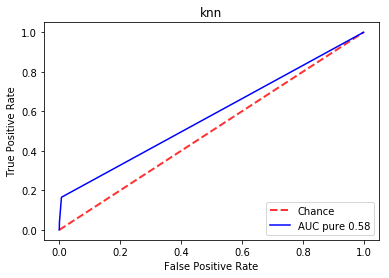

KNN Classifier
SMOTE
10 fold cross-validations TP: 125
10 fold cross-validations FP: 10183
10 fold cross-validations FN: 220
10 fold cross-validations TN: 212644


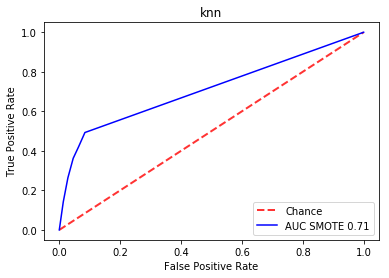

KNN Classifier
SMOTE + Tomek
10 fold cross-validations TP: 124
10 fold cross-validations FP: 10252
10 fold cross-validations FN: 221
10 fold cross-validations TN: 212575


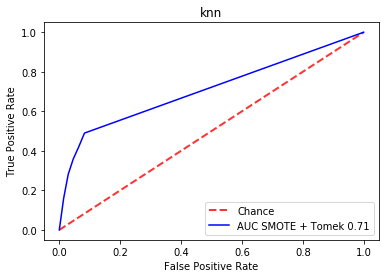

KNN Classifier
UnderSampling
10 fold cross-validations TP: 4
10 fold cross-validations FP: 50
10 fold cross-validations FN: 341
10 fold cross-validations TN: 222777


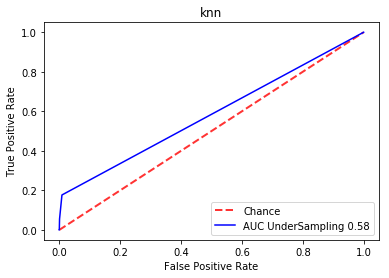

In [9]:
classification('pure', 'knn')
classification('SMOTE', 'knn')
classification('SMOTE + Tomek', 'knn')
classification('UnderSampling', 'knn')

Random Forest Classifier
Wihtout data augmentation
10 fold cross-validations TP: 24
10 fold cross-validations FP: 46
10 fold cross-validations FN: 321
10 fold cross-validations TN: 222781


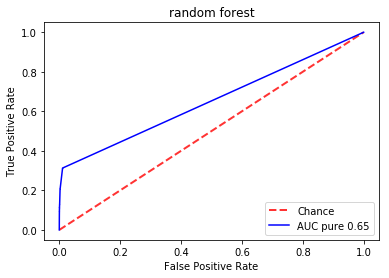

Random Forest Classifier
SMOTE
10 fold cross-validations TP: 54
10 fold cross-validations FP: 295
10 fold cross-validations FN: 291
10 fold cross-validations TN: 222532


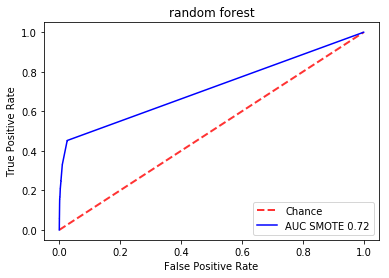

Random Forest Classifier
SMOTE + Tomek
10 fold cross-validations TP: 42
10 fold cross-validations FP: 325
10 fold cross-validations FN: 303
10 fold cross-validations TN: 222502


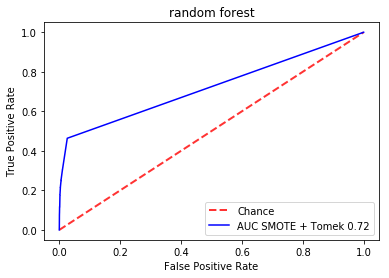

Random Forest Classifier
UnderSampling
10 fold cross-validations TP: 22
10 fold cross-validations FP: 42
10 fold cross-validations FN: 323
10 fold cross-validations TN: 222785


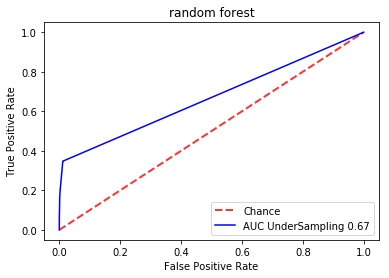

In [10]:
classification('pure', 'random forest')
classification('SMOTE', 'random forest')
classification('SMOTE + Tomek', 'random forest')
classification('UnderSampling', 'random forest')

AdaBoost Classifier
Wihtout data augmentation
10 fold cross-validations TP: 6
10 fold cross-validations FP: 17
10 fold cross-validations FN: 339
10 fold cross-validations TN: 222810


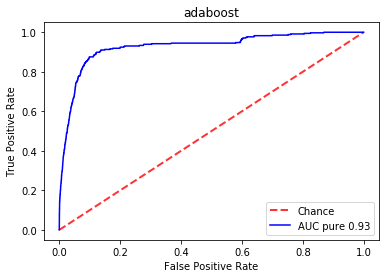

AdaBoost Classifier
SMOTE
10 fold cross-validations TP: 219
10 fold cross-validations FP: 10163
10 fold cross-validations FN: 126
10 fold cross-validations TN: 212664


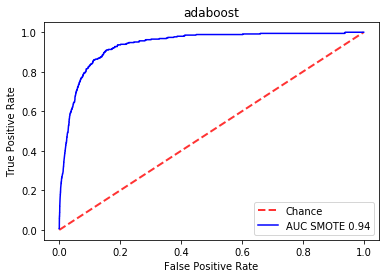

AdaBoost Classifier
SMOTE + Tomek
10 fold cross-validations TP: 226
10 fold cross-validations FP: 10410
10 fold cross-validations FN: 119
10 fold cross-validations TN: 212417


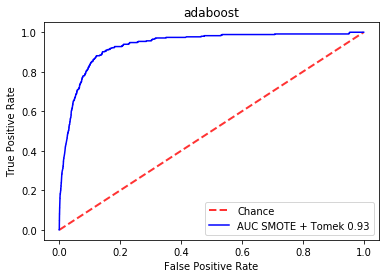

AdaBoost Classifier
UnderSampling
10 fold cross-validations TP: 10
10 fold cross-validations FP: 21
10 fold cross-validations FN: 335
10 fold cross-validations TN: 222806


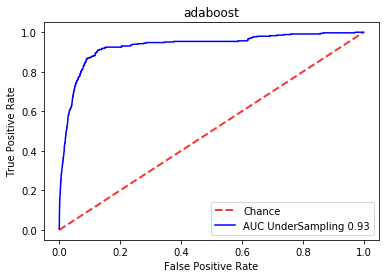

In [11]:
classification('pure', 'adaboost')
classification('SMOTE', 'adaboost')
classification('SMOTE + Tomek', 'adaboost')
classification('UnderSampling', 'adaboost')

Decision Tree Classifier
Wihtout data augmentation
10 fold cross-validations TP: 36
10 fold cross-validations FP: 381
10 fold cross-validations FN: 309
10 fold cross-validations TN: 222446


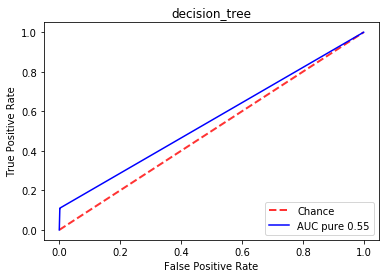

Decision Tree Classifier
SMOTE
10 fold cross-validations TP: 53
10 fold cross-validations FP: 707
10 fold cross-validations FN: 292
10 fold cross-validations TN: 222120


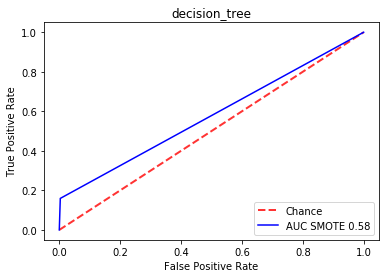

Decision Tree Classifier
SMOTE + Tomek
10 fold cross-validations TP: 56
10 fold cross-validations FP: 724
10 fold cross-validations FN: 289
10 fold cross-validations TN: 222103


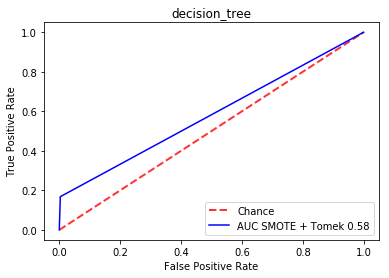

Decision Tree Classifier
UnderSampling
10 fold cross-validations TP: 52
10 fold cross-validations FP: 424
10 fold cross-validations FN: 293
10 fold cross-validations TN: 222403


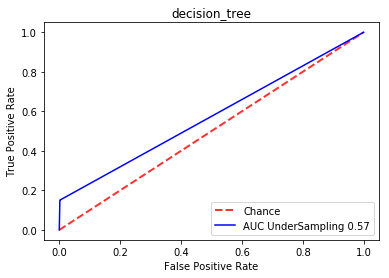

In [12]:
classification('pure', 'decision_tree')
classification('SMOTE', 'decision_tree')
classification('SMOTE + Tomek', 'decision_tree')
classification('UnderSampling', 'decision_tree')

KNN Classifier
SMOTE
10 fold cross-validations TP: 125
10 fold cross-validations FP: 10183
10 fold cross-validations FN: 220
10 fold cross-validations TN: 212644


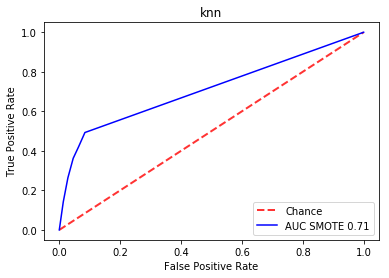

In [15]:
classification('SMOTE', 'knn')